# EVT Path: 

cp /homes/dmrowan/NicerData/ExampleEVT/1937_events.evt .

In [19]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from niutils import plotparams

from astropy.table import Table

In [28]:
tab = Table.read('1937_events.evt', hdu=1)
tab

TIME,RAWX,RAWY,PHA,PHA_FAST,DET_ID,DEADTIME,EVENT_FLAGS [8],TICK,MPU_A_TEMP,MPU_UNDER_COUNT,PI_FAST,PI,PI_RATIO,PULSE_PHASE
s,pix,pix,chan,chan,,s,,,Celsius,,chan,chan,,
float64,uint8,uint8,int16,int16,uint8,float64,bool,int64,float64,int32,int16,int16,float32,float64
110092734.163869113,4,6,658,--,30,0.000015195,False .. False,27372793382573,35.488,2,--,132,nan,0.25150223076343536
110092736.183132783,4,6,375,--,30,0.000015195,False .. False,27372845486617,35.488,2,--,31,nan,0.5164873450994492
110092736.588509619,4,0,590,537,17,0.000022637,False .. False,27376866386826,34.321,2,78,87,1.1153846,0.7478716820478439
110092737.984718546,2,0,668,--,37,0.000015195,False .. False,27372891973812,35.488,2,--,103,nan,0.04323413968086243
110092741.398286685,1,1,1771,1676,46,0.000022637,False .. False,27370028937001,33.579,3,533,532,0.9981238,0.3808726817369461
110092742.323651791,0,5,1639,1564,63,0.000022637,False .. False,27366372949450,32.201,5,473,474,1.0021142,0.41832685470581055
110092743.048320368,7,5,2959,2764,1,0.000022637,False .. False,27379491145885,33.579,2,970,1005,1.0360825,0.6187706142663956
110092745.029541537,7,3,1175,1115,3,0.000022637,False .. False,27379542268410,33.473,2,304,313,1.0296053,0.46219660341739655


In [12]:
tab.meta

OrderedDict([('EXTNAME', 'EVENTS'),
             ('HDUCLASS', 'OGIP'),
             ('HDUCLAS1', 'EVENTS'),
             ('DATAMODE', 'PHOTON'),
             ('DATE', '2018-03-04T00:29:35'),
             ('EXPOSURE', 834312),
             ('ONTIME', 834312),
             ('TIMEPIXR', 0.0),
             ('TIMEDEL', 4e-08),
             ('TIMEZERO', -1.0),
             ('TLMIN2', 0),
             ('TLMAX2', 7),
             ('TLMIN3', 0),
             ('TLMAX3', 6),
             ('TLMIN4', 0),
             ('TLMAX4', 4095),
             ('TLMIN5', 0),
             ('TLMAX5', 4095),
             ('TLMIN7', 3.101e-07),
             ('TLMAX7', 7.90755e-05),
             ('comments',
              ['  DEADTIME is approximate MPU deadtime on a per-event basis. Each MPU',
               '  is independent of the others.  MPU dead-time is quantized in steps',
               '  of 620.2 ns.  True dead time may be anywhere within this step, but',
               '  this FITS file records the center

In [13]:
#Most useful things in meta is exposure and date

print(tab.meta['DATE'])
print(tab.meta['EXPOSURE'])

2018-03-04T00:29:35
834312


In [14]:
def convert_time(time):
    timezero = datetime.datetime(year=2014, month=1,
                                 day=1, hour=0, minute=0, second=0)
    new_time = timezero+datetime.timedelta(seconds=time)

    return new_time


In [16]:
time_example = convert_time(142039018.640167803)
print(time_example)

2018-07-02 23:16:58.640168


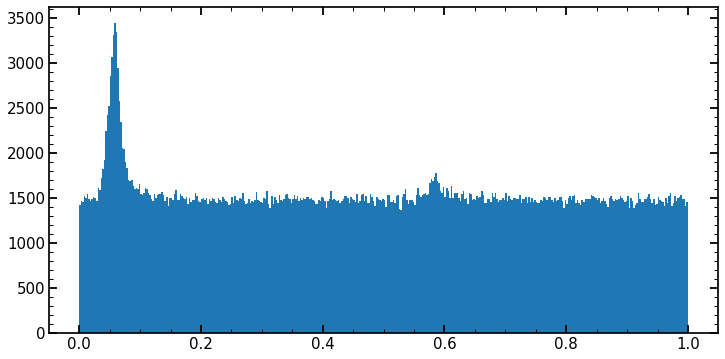

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax = plotparams(ax)

ax.hist(tab['PULSE_PHASE'], bins=400)
plt.show()